In [33]:
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats import proportion
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats.power import tt_ind_solve_power, zt_ind_solve_power

from math import asin
import plotly.graph_objects as go
import plotly.exceptions as px
from tqdm import tqdm_notebook
from typing import Union

In [34]:
data = pd.read_csv('/data/notebook_files/результаты А_B - cookie_cats 2.csv')

In [35]:
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [37]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [51]:
data.userid.value_counts()

116 1
6632278 1
6658202 1
6658194 1
6658134 1
 ..
3347358 1
3347337 1
3346992 1
3346979 1
9999861 1
Name: userid, Length: 90189, dtype: int64

In [39]:
def is_normal_distr(x):
    if x.size < 5_000:
        _, pvalue = stats.shapiro(x)
    else:
        _, pvalue = stats.shapiro(x, 'norm')

    return pvalue

In [40]:
# Подсчет количества игроков в каждой группе
data.groupby('version')['version'].count()

version
gate_30 44700
gate_40 45489
Name: version, dtype: int64

In [41]:
plot_data = data.groupby('sum_gamerounds').count().reset_index()
plot_data.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


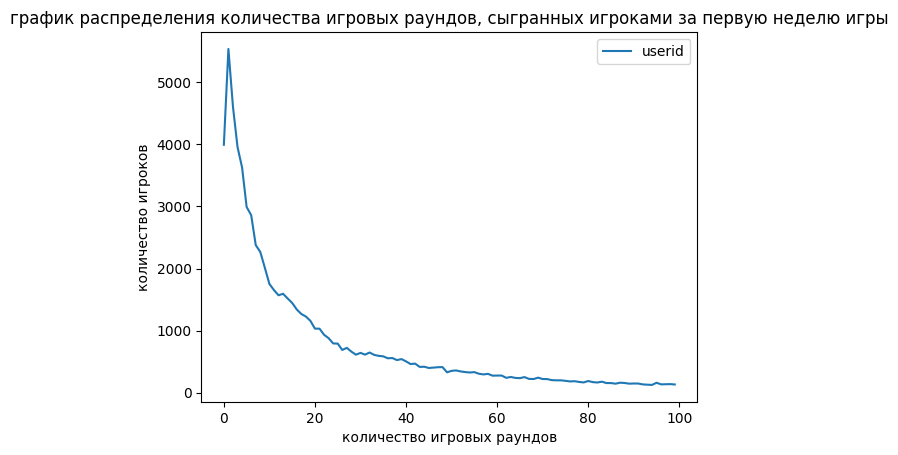

In [42]:
%matplotlib inline

# Подсчет количества игроков для каждого количества игровых раундов
plot_data = data.groupby('sum_gamerounds').count().reset_index()

# Построение графика распределения игроков, сыгравших от 0 до 100 игровых раундов
ax = plot_data.head(n=100).plot('sum_gamerounds', 'userid')
ax.set_xlabel("количество игровых раундов")
ax.set_ylabel("количество игроков")
ax.set_title("график распределения количества игровых раундов, сыгранных игроками за первую неделю игры");

# **В приведенном выше графике видно, что некоторые игроки устанавливают игру, но затем никогда в нее не играют (0 игровых раундов), некоторые игроки просто играют пару игровых раундов в первую неделю, а некоторые по-настоящему увлекаются**

In [43]:
# % пользователей, которые вернулись на следующий день после установки игры
data['retention_1'].mean()

0.4452095044850259

In [44]:
#Расчет 1-дневного удержания для каждой группы
data.groupby('version')['retention_1'].mean()

version
gate_30 0.448188
gate_40 0.442283
Name: retention_1, dtype: float64

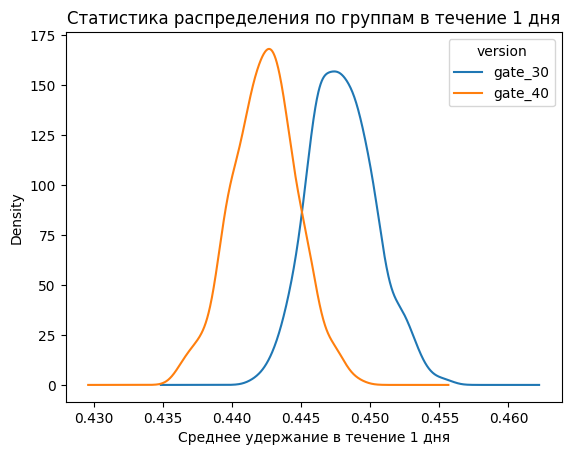

In [45]:
boot_1d = []
iterations=500
for i in range(iterations):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
    
ax = boot_1d.plot.kde()
ax.set_title('Статистика распределения по группам в течение 1 дня')
ax.set_xlabel('Среднее удержание в течение 1 дня');

In [46]:
boot_1d.head()

version,gate_30,gate_40
retention_1,0.447728,0.444018
retention_1,0.448552,0.441101
retention_1,0.449324,0.441641
retention_1,0.449783,0.441585
retention_1,0.450537,0.443555


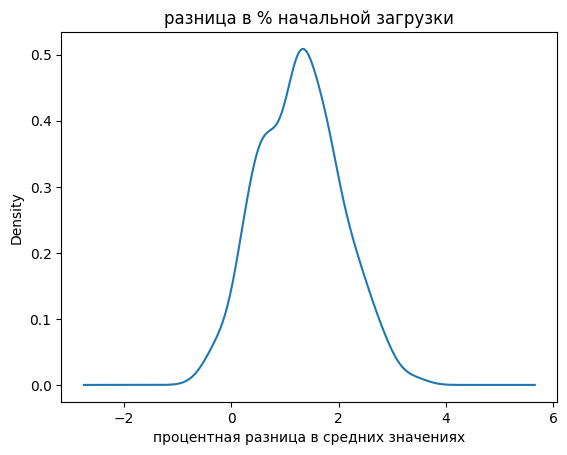

In [47]:
boot_1d['diff'] = ((boot_1d.gate_30 - boot_1d.gate_40)
                   / boot_1d.gate_40 * 100)

# Построение графика разницы в % начальной загрузки
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('процентная разница в средних значениях')
ax.set_title('разница в % начальной загрузки');


Из этого графика очевидно, что наиболее вероятная разница в процентах составляет около 1-2%, и что большая часть распределения выше 0% в пользу ворот на уровне 30

In [48]:
#вероятность того, что 1-дневное удержание больше, когда ворота находятся на уровне 30
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])

'{0:.1%}'.format(prob)

'96.4%'

# Анализ начальной загрузки говорит, что существует высокая вероятность того, что 1-дневное удержание лучше, когда ворота находятся на уровне 30. Однако, поскольку игроки играют в игру всего один день, вполне вероятно, что большинство игроков еще не достигли 30-го уровня.

# После недельной игры большее количество игроков должно было достичь 40-го уровня, и поэтому имеет смысл также рассмотреть возможность 7-дневного удержания. То есть: какой процент людей, установивших игру, также пришли неделю спустя, чтобы снова поиграть в игру.

In [49]:
# 7-дневное удержание для обеих групп
data.groupby('version')['retention_7'].mean()

version
gate_30 0.190201
gate_40 0.182000
Name: retention_7, dtype: float64

# Как и в случае с 1-дневным удержанием, мы видим, что 7-дневное удержание немного ниже (18,2%), когда врата находятся на 40 уровне, чем когда врата находятся на 30 уровне (19,0%). Эта разница также больше, чем при удержании в течение 1 дня, предположительно, потому, что больше игроков успели поразить первые ворота. Мы также видим, что общее 7-дневное удержание ниже, чем общее 1-дневное удержание; меньше людей играют в игру через неделю после установки, чем через день после установки.

'99.8%'

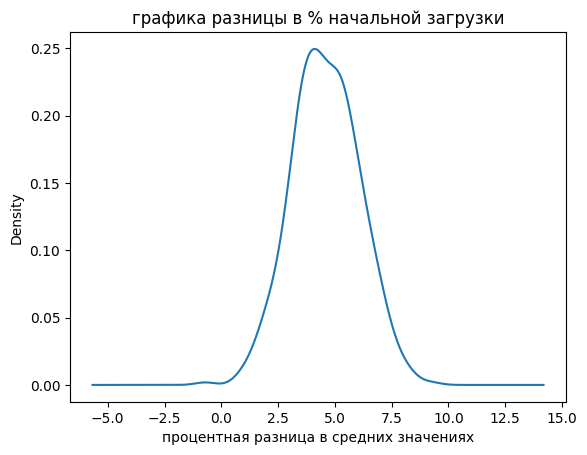

In [50]:
boot_7d = []
for i in range(500):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / 
                   boot_7d['gate_40'] * 100)

# Построение графика разницы в % начальной загрузки
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('процентная разница в средних значениях')
ax.set_title('графика разницы в % начальной загрузки');

# Вычисление вероятности того, что 7-дневное удержание будет больше, когда врата находятся на уровне 30
prob = (boot_7d['diff'] > 0).mean()

'{0:.1%}'.format(prob)

# Заключение

# Результат начальной загрузки говорит нам, что есть убедительные доказательства того, что 7-дневное удержание выше, когда ворота находятся на уровне 30, чем когда они находятся на уровне 40. Вывод таков: если мы хотим сохранить удержание на высоком уровне — как 1-дневное, так и 7-дневное — нам не следует перемещать ворота с 30-го уровня на 40-й. Когда ворота перемещаются на 40-й уровень, меньшему количеству игроков удается пройти достаточно далеко, и они с большей вероятностью выйдут из игры, потому что им это просто наскучило.

# Конечно, есть и другие показатели, на которые мы могли бы обратить внимание, например, количество сыгранных игровых раундов или объем внутриигровых покупок, совершенных двумя группами. Но удержание - один из самых важных показателей. Если мы не сохраним нашу базу игроков, не имеет значения, сколько денег они тратят в игре.